In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

## Data Preprocessing

In [3]:
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   43824 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.3+ MB


In [4]:
columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
scaler = StandardScaler()
transformed_data = data[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']]
transformed_data = scaler.fit_transform(transformed_data)
transformed_data = pd.DataFrame(transformed_data, columns=columns)
transformed_data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,-1.018534,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667
1,-1.018534,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667
2,-1.018534,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667
3,-1.018534,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667
4,-1.018534,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667


In [5]:
le = LabelEncoder()
cbwd = data['cbwd']
transformed_cbwd = le.fit_transform(cbwd)
transformed_data['cbwd'] = transformed_cbwd
transformed_data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd
0,-1.018534,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1
1,-1.018534,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1
2,-1.018534,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1
3,-1.018534,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1
4,-1.018534,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1


In [6]:
date_list = list()
for i in range(len(data)):
    year = int(data.iloc[i]['year'])
    month = int(data.iloc[i]['month'])
    day = int(data.iloc[i]['day'])
    hour = int(data.iloc[i]['hour'])
    date_list.append(dt.datetime(year, month, day, hour))
transformed_data.index = date_list
transformed_data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd
2010-01-01 00:00:00,-1.018534,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1
2010-01-01 01:00:00,-1.018534,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1
2010-01-01 02:00:00,-1.018534,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1
2010-01-01 03:00:00,-1.018534,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1
2010-01-01 04:00:00,-1.018534,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1


## data split

In [7]:
train_start = dt.datetime(2010, 1, 1, 0)
train_end = dt.datetime(2012, 12, 31, 23)
train = transformed_data.loc[train_start: train_end]

valid_start = dt.datetime(2013, 1, 1, 0)
valid_end = dt.datetime(2013, 12, 31, 23)
valid = transformed_data[valid_start: valid_end]

test_start = dt.datetime(2014, 1, 1, 0)
test_end = dt.datetime(2014, 12, 31 ,23)
test = transformed_data[test_start:test_end]

In [8]:
def dataprocessing(transformed_df):
    X_data, y_data = list(), list()
    for i in tqdm(range(0, len(transformed_df) - 36)):
        pm = transformed_df.iloc[i : i + 24]['pm2.5']
        dewp = transformed_df.iloc[i : i + 24]['DEWP']
        temp = transformed_df.iloc[i : i + 24]['TEMP']
        pres = transformed_df.iloc[i : i + 24]['PRES']
        lws = transformed_df.iloc[i : i + 24]['Iws']
        cbwd = transformed_df.iloc[i : i + 24]['cbwd']
        Is = transformed_df.iloc[i : i + 24]['Is']
        Ir = transformed_df.iloc[i : i + 24]['Ir']
        X_data.append([pm, dewp, temp, pres, lws, cbwd, Is, Ir])
        
        pm = transformed_df.iloc[i + 24]['pm2.5']
        y_data.append(pm)
#     print(X_data)
#     print(y_data)
    return torch.Tensor(X_data), torch.Tensor(y_data)

In [9]:
X_train, y_train = dataprocessing(train)
X_valid, y_valid = dataprocessing(valid)
X_test, y_test = dataprocessing(test)

100%|██████████| 8724/8724 [02:03<00:00, 70.89it/s]


In [10]:
print('X Train shape ', X_train.shape)
print('X Valid shape ', X_valid.shape)
print('X Test shape', X_test.shape)

X Train shape  torch.Size([26268, 8, 24])
X Valid shape  torch.Size([8724, 8, 24])
X Test shape torch.Size([8724, 8, 24])


In [11]:
batch_size = 1

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=128)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=128)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Model

In [12]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultivariateLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(960, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 1)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(32)
        
        self.act = nn.ReLU()
    def forward(self, inp):
        h0, c0 = self.init_hidden(inp)
        output, (h_t, c_t) = self.lstm(inp, (h0, c0))
        output = self.flatten(output)
        output = self.act(self.bn1(self.fc1(output)))
        output = self.act(self.bn2(self.fc2(output)))
        output = self.act(self.bn3(self.fc3(output)))
        output = self.act(self.bn4(self.fc4(output)))
        output = self.fc5(output)
        return output
        
    def init_hidden(self, inp):
        b, seq_len, c = inp.size()
        h0 = torch.zeros(1, b, self.hidden_dim)
        c0 = torch.zeros(1, b, self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [13]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
    X = X.reshape(-1, 24, 8)
    model = MultivariateLSTM(8, 40).cuda()
    output = model(X.cuda())
    criterion = nn.MSELoss().cuda()
    print(output.shape)
    print(output)
    loss = criterion(output.reshape(-1, 1), y.cuda())
    print(loss)

torch.Size([128, 8, 24])
torch.Size([128])
torch.Size([128, 1])
tensor([[ 2.1311e-01],
        [ 5.2878e-01],
        [ 5.6514e-01],
        [ 4.6798e-01],
        [ 4.8833e-01],
        [ 3.1285e-01],
        [ 5.1052e-01],
        [ 2.1254e-01],
        [-1.0638e-01],
        [ 2.3787e-01],
        [ 1.2780e-01],
        [-2.0905e-01],
        [ 3.5575e-02],
        [ 5.4847e-02],
        [ 3.9274e-02],
        [ 5.6178e-01],
        [-6.5211e-02],
        [-3.3713e-01],
        [ 2.7159e-01],
        [ 1.1038e-01],
        [-2.5140e-02],
        [ 1.6713e-01],
        [ 2.5647e-01],
        [-3.2681e-02],
        [-1.2330e-01],
        [-1.4260e-01],
        [-2.2286e-01],
        [-1.1921e-01],
        [-3.5027e-01],
        [-2.0968e-01],
        [-3.8819e-01],
        [-2.6434e-01],
        [-4.6470e-01],
        [-5.8551e-01],
        [-2.3142e-01],
        [-2.0584e-01],
        [-1.5960e-01],
        [-7.7393e-02],
        [ 1.3174e-02],
        [-7.3468e-02],
        [-1.3298

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Train

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='singleLSTM_pm2.5.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
model = MultivariateLSTM(8, 40).cuda()

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 20
n_epochs = 300

print(model)

MultivariateLSTM(
  (lstm): LSTM(8, 40, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [16]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1, 1), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1, 1), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('singleLSTM_pm2.5.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [20]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
        y_test.append(target.cpu().numpy())
        output = model(data)
        y_hat.append(output.reshape(-1, 1).detach().cpu().numpy())
        loss = criterion(output.reshape(1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [53]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 1.00386 valid_loss: 1.26990
Validation loss decreased (inf --> 1.269899).  Saving model ...
[  2/300] train_loss: 0.93568 valid_loss: 1.21755
Validation loss decreased (1.269899 --> 1.217547).  Saving model ...
[  3/300] train_loss: 0.90670 valid_loss: 1.19381
Validation loss decreased (1.217547 --> 1.193806).  Saving model ...
[  4/300] train_loss: 0.88646 valid_loss: 1.18796
Validation loss decreased (1.193806 --> 1.187964).  Saving model ...
[  5/300] train_loss: 0.86930 valid_loss: 1.19709
EarlyStopping counter: 1 out of 20
[  6/300] train_loss: 0.85427 valid_loss: 1.18834
EarlyStopping counter: 2 out of 20
[  7/300] train_loss: 0.84130 valid_loss: 1.19276
EarlyStopping counter: 3 out of 20
[  8/300] train_loss: 0.82816 valid_loss: 1.19486
EarlyStopping counter: 4 out of 20
[  9/300] train_loss: 0.81672 valid_loss: 1.19101
EarlyStopping counter: 5 out of 20
[ 10/300] train_loss: 0.80618 valid_loss: 1.18263
Validation loss decreased (1.187964 --> 1.182629).  Sa

In [18]:
model.load_state_dict(torch.load('singleLSTM_pm2.5.pth'))

<All keys matched successfully>

In [21]:
test_loss, y_test, y_hat = evaluate_model(model, test_loader)

In [22]:
test_loss

1.0974463186421899

In [23]:
target, predicted = list(), list()
for i in range(len(y_test)):
    target.append(y_test[i].item())
    predicted.append(y_hat[i][0].item())

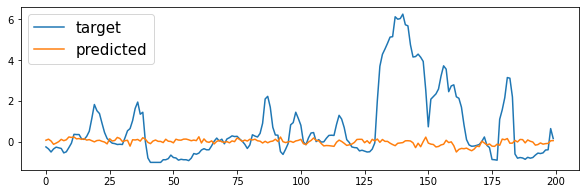

In [24]:
plt.figure(figsize=(10, 3))
plt.plot(target[200:400], label='target')
plt.plot(predicted[200:400], label='predicted')
plt.legend(loc='upper left', fontsize=15)
plt.show()

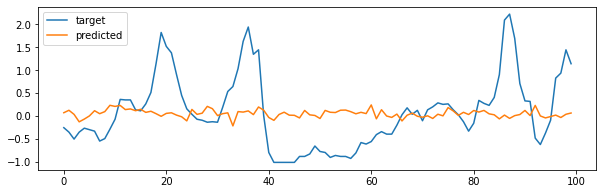

In [25]:
plt.figure(figsize=(10, 3))
plt.plot(target[200:300], label='target')
plt.plot(predicted[200:300], label='predicted')
plt.legend()
plt.show()

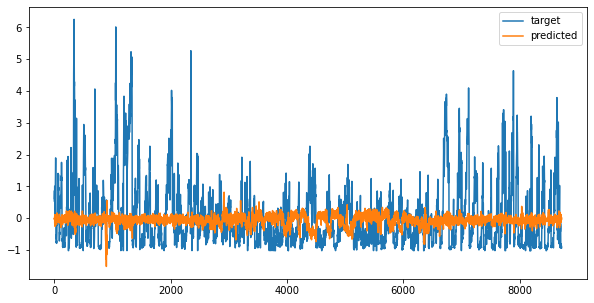

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(target, label='target')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()